In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from models.hawkes_model import HawkesModelGeneral, IndHawkesModel
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup


from utils.plots import DistributionPlotter
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, CellPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
import pickle
from utils.utils import pshape, pmax, pmin, pmean, get_data_sub_paths
import os

%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_models,\
                                get_models_metrics, get_models_results, get_metrics_table, get_all_metrics
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, \
                                    TriangularMovingAverage, HistoricAverage

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
data_sub_paths = get_data_sub_paths()
data_sub_paths

['T3H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X85M-Y110M_2013-01-01_2015-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2017-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01']

In [3]:
# run HAWKES INDEPENDENT MODEL for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------ HAWKES INDEPENDENT MODEL
    conf.model_name = f"Ind-Hawkes Model"  # tod add the actual parameters as well
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = IndHawkesModel(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)

    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES INDEPENDENT MODEL    

2019-11-21T15:31:48 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-21T15:31:48 | root | INFO | 	t_range shape (5841,)
fitted historic average: step (8) and max_steps (-1)
2019-11-21T15:31:56 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:32:27 | root | INFO | f1_score: 0.32637869059962127 at index 2182376, new threshold 0.06785835856385787
2019-11-21T15:32:31 | root | INFO | 
        MODEL METRICS
            Model Name: Ind-Hawkes Model
                MAE:                0.11284495161142978
                RMSE:               0.2803834748916959
                ROC AUC:            0.7321386906755737                
                Average Precision:  0.2291163853985274
                Precision:          0.21376896149358227
                Recall:             0.4264863661207717
                Accuracy:           0.811341812593377
                MCC:                0.20477

2019-11-21T15:35:58 | root | INFO | 
        MODEL METRICS
            Model Name: Ind-Hawkes Model
                MAE:                0.2039874608399319
                RMSE:               0.3547628288420766
                ROC AUC:            0.7407903458975464                
                Average Precision:  0.3636363620947402
                Precision:          0.30303824563702686
                Recall:             0.6148187538775148
                Accuracy:           0.7100943241294119
                MCC:                0.2689982814270646          
        
2019-11-21T15:35:58 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X425M-Y440M_2013-01-01_2015-01-01
2019-11-21T15:35:58 | root | INFO | 	t_range shape (731,)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T15:35:59 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:36:09 | root | INFO | f1_score: 0.4719092614305632 at index 565090, new t

In [4]:
# run HAWKES GENERAL MODEL for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------ HAWKES GENERAL MODEL
    conf.model_name = f"Hawkes General Model"  # tod add the actual parameters as well
    conf.model_path = conf.data_path + f"models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = HawkesModelGeneral(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)

    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES GENERAL MODEL    

2019-11-21T15:38:40 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-21T15:38:40 | root | INFO | 	t_range shape (5841,)
fitted historic average: step (8) and max_steps (-1)
2019-11-21T15:38:48 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:38:52 | root | INFO | f1_score: 0.2798947277505155 at index 1895189, new threshold 0.042487741931144886
2019-11-21T15:38:57 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                MAE:                0.10584339755872853
                RMSE:               0.2859766887541792
                ROC AUC:            0.6997021661401248                
                Average Precision:  0.18977006876703584
                Precision:          0.18642744276632492
                Recall:             0.4107977894289358
                Accuracy:           0.79022032526413
                MCC:                0.1

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-21T15:39:15 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T1H-X1700M-Y1760M_2013-01-01_2015-01-01
2019-11-21T15:39:15 | root | INFO | 	t_range shape (17521,)
fitted historic average: step (24) and max_steps (-1)
2019-11-21T15:39:32 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:39:39 | root | INFO | f1_score: 0.3278080672612949 at index 1894606, new threshold 0.05640193191095497
2019-11-21T15:39:55 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                MAE:                0.12720205318197525
                RMSE:               0.30603157318276347
                ROC AUC:            0.728311898785172                
                Average Precision:  0.23838315406795177
                Precision:          0.22524578472823595
                Recall:             0.46000998709999585
                Accuracy:           0.7797031146397355
                MCC:             

2019-11-21T15:40:40 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                MAE:                0.44058773722139805
                RMSE:               0.5632874358472585
                ROC AUC:            0.764971443049523                
                Average Precision:  0.7255111835549484
                Precision:          0.5816552825334871
                Recall:             0.8408835882145491
                Accuracy:           0.657155601600046
                MCC:                0.36306539878181265          
        
2019-11-21T15:40:40 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T1H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-21T15:40:41 | root | INFO | 	t_range shape (17521,)
fitted historic average: step (24) and max_steps (-1)
2019-11-21T15:42:02 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:42:21 | root | INFO | f1_score: 0.13602766431413102 at index 5057021

2019-11-21T15:42:45 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-21T15:42:45 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:42:45 | root | INFO | 	t_range shape (5841,)
fitted historic average: step (8) and max_steps (-1)
2019-11-21T15:43:00 | root | INFO | class distribution: {0.0: 0.903336392632505, 1.0: 0.09666360736749502}


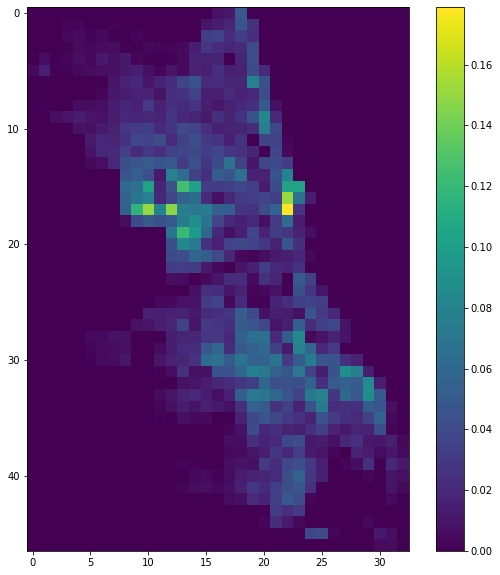

2019-11-21T15:43:02 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:43:02 | root | INFO | using time step: 8
fitted historic average: step (8) and max_steps (-1)
fitted historic average: step (8) and max_steps (-1)
2019-11-21T15:43:18 | root | INFO | f1_score: 0.3212160807528689 at index 363293, new threshold 0.04776034121523081
2019-11-21T15:43:18 | root | INFO | ======== ./data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T15:43:27 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.10631369857733719
                RMSE:               0.2832087514992468
                ROC AUC:            0.753654811550142                
                Average Precision:  0.24615196645788504
                Precision:          0.22766338771104458
                Recall:             0.4525800117411284
                Accuracy

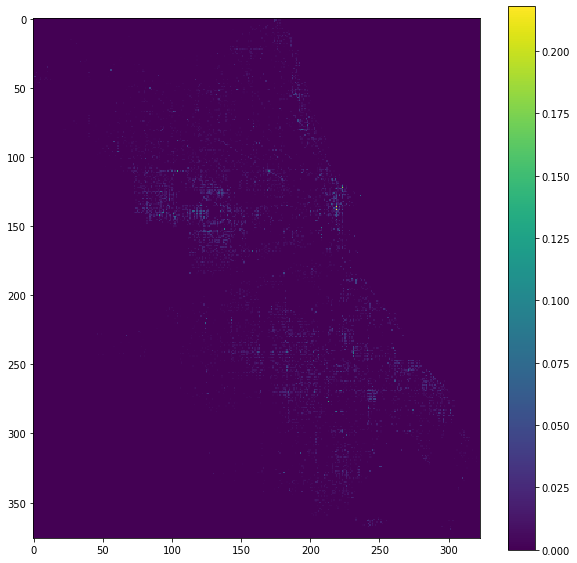

2019-11-21T15:44:14 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:44:14 | root | INFO | using time step: 1
fitted historic average: step (1) and max_steps (-1)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T15:44:31 | root | INFO | f1_score: 0.17745096195437532 at index 129281, new threshold 0.025860103615152823
2019-11-21T15:44:31 | root | INFO | ======== ./data/processed/T24H-X85M-Y110M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T15:44:39 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.04884401961605012
                RMSE:               0.19565822956385032
                ROC AUC:            0.6860798590300157                
                Average Precision:  0.10954291345757508
                Precision:          0.13596624107336075
                Recall:             0.22832327930808924
                Acc

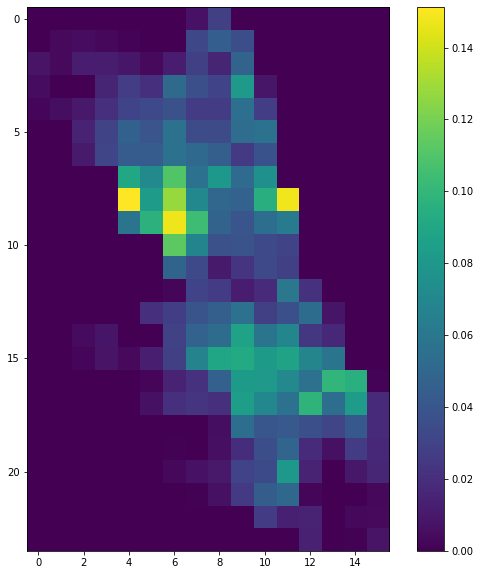

2019-11-21T15:45:30 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:45:30 | root | INFO | using time step: 24
fitted historic average: step (24) and max_steps (-1)
fitted historic average: step (24) and max_steps (-1)
2019-11-21T15:45:50 | root | INFO | f1_score: 0.3476719285487571 at index 287867, new threshold 0.0611313380308896
2019-11-21T15:45:50 | root | INFO | ======== ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/Historic Average/  ========


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-21T15:46:12 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.128158132454801
                RMSE:               0.3030390939668656
                ROC AUC:            0.7556823278828275                
                Average Precision:  0.26867240677981113
                Precision:          0.24477907788149392
                Recall:             0.5035995172901668
                Accuracy:           0.7871846429967582
                MCC:                0.24085970509267918          
        
2019-11-21T15:46:12 | root | INFO | =====================================END=====================================

2019-11-21T15:46:12 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:46:14 | root | INFO | f1_score: 0.32454317375779557 at index 144, new threshold 0.05532401367602441
2019-11-21T15:46:14 | root | INFO | ======== ./data/processed/T1H-X1700M-Y1760

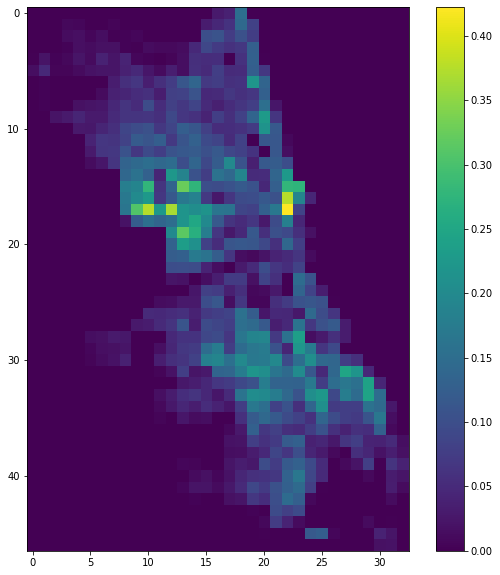

2019-11-21T15:47:10 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:47:10 | root | INFO | using time step: 2
fitted historic average: step (2) and max_steps (-1)
fitted historic average: step (2) and max_steps (-1)
2019-11-21T15:47:17 | root | INFO | f1_score: 0.587164992272594 at index 246757, new threshold 0.0741569202888866
2019-11-21T15:47:17 | root | INFO | ======== ./data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T15:47:21 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.2888145946056031
                RMSE:               0.46548217039508694
                ROC AUC:            0.7687079617503436                
                Average Precision:  0.5702475801519207
                Precision:          0.4499859773768346
                Recall:             0.7414890885750963
                Accuracy: 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-21T15:47:30 | root | INFO | 	t_range shape (1462,)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T15:47:32 | root | INFO | class distribution: {0.0: 0.5417526074097135, 1.0: 0.4582473925902864}


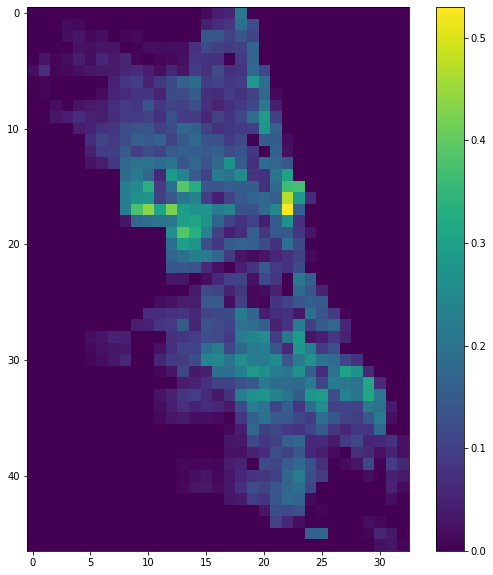

2019-11-21T15:47:33 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:47:33 | root | INFO | using time step: 1
fitted historic average: step (1) and max_steps (-1)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T15:47:45 | root | INFO | f1_score: 0.714276227205399 at index 310542, new threshold 0.07978497289730052
2019-11-21T15:47:45 | root | INFO | ======== ./data/processed/T24H-X850M-Y880M_2013-01-01_2017-01-01/models/Historic Average/  ========
2019-11-21T15:47:46 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.41844679477894586
                RMSE:               0.568508138562375
                ROC AUC:            0.7800980539181653                
                Average Precision:  0.7322579143133201
                Precision:          0.6050113351628684
                Recall:             0.8186309331611237
                Accuracy: 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-21T15:47:52 | root | INFO | 	t_range shape (731,)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T15:48:02 | root | INFO | class distribution: {0.0: 0.9037695806805341, 1.0: 0.09623041931946581}


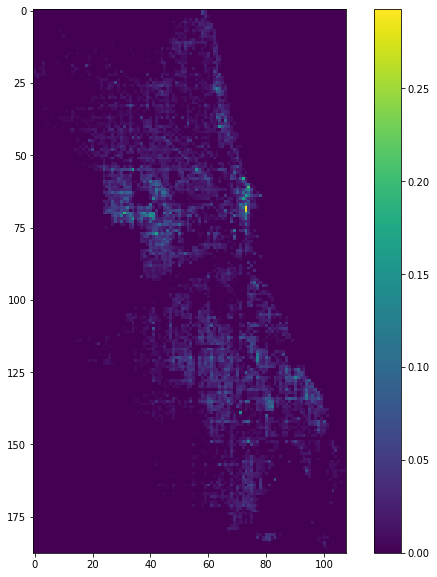

2019-11-21T15:48:05 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:48:05 | root | INFO | using time step: 1
fitted historic average: step (1) and max_steps (-1)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T15:48:23 | root | INFO | f1_score: 0.28365505212939723 at index 307358, new threshold 0.03862526839028725
2019-11-21T15:48:23 | root | INFO | ======== ./data/processed/T24H-X255M-Y220M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T15:48:30 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.10430578243518321
                RMSE:               0.2850607290555881
                ROC AUC:            0.7029747083145329                
                Average Precision:  0.2110511291240894
                Precision:          0.20760140936438684
                Recall:             0.3829512658673362
                Accura

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-21T15:48:50 | root | INFO | 
        MODEL METRICS
            Model Name: Previous Time Step
                MAE:                0.10182371289295147
                RMSE:               0.2928497596321323
                ROC AUC:            0.537794062735584                
                Average Precision:  0.10096434415653145
                Precision:          0.08723301914791276
                Recall:             1.0
                Accuracy:           0.08723301914791276
                MCC:                0.0          
        
2019-11-21T15:48:50 | root | INFO | =====================================END=====================================

2019-11-21T15:48:50 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T6H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-21T15:48:50 | root | INFO | =====================================BEGIN===============================

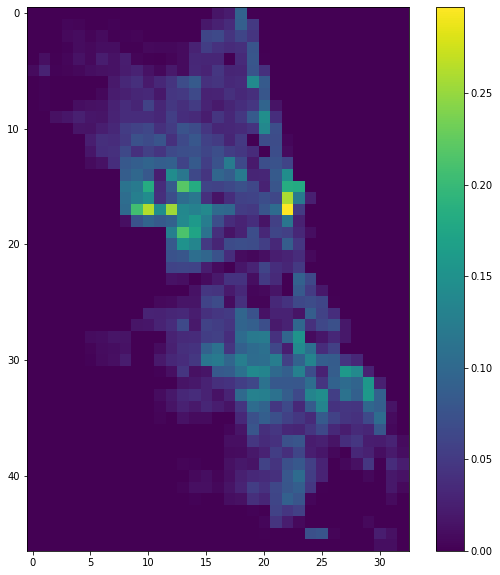

2019-11-21T15:48:58 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:48:58 | root | INFO | using time step: 4
fitted historic average: step (4) and max_steps (-1)
fitted historic average: step (4) and max_steps (-1)
2019-11-21T15:49:14 | root | INFO | f1_score: 0.44527491317378387 at index 449823, new threshold 0.06408993340449541
2019-11-21T15:49:14 | root | INFO | ======== ./data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T15:49:22 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.18357719814243492
                RMSE:               0.36995551013061556
                ROC AUC:            0.7574206906512297                
                Average Precision:  0.3898930799531727
                Precision:          0.3287441608223534
                Recall:             0.5909775768855801
                Accurac

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-21T15:49:49 | root | INFO | 	t_range shape (731,)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T15:49:53 | root | INFO | class distribution: {0.0: 0.7935492336136458, 1.0: 0.20645076638635415}


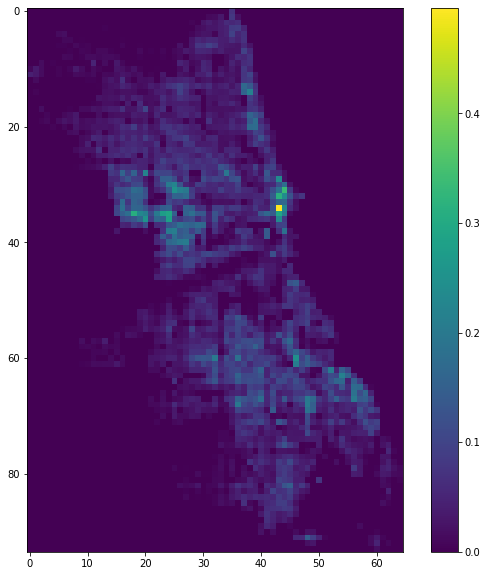

2019-11-21T15:49:54 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:49:54 | root | INFO | using time step: 1
fitted historic average: step (1) and max_steps (-1)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T15:50:02 | root | INFO | f1_score: 0.4577208654866075 at index 392340, new threshold 0.060700270586642624
2019-11-21T15:50:02 | root | INFO | ======== ./data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T15:50:06 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.21112410783854843
                RMSE:               0.40117160251173134
                ROC AUC:            0.7309476776844464                
                Average Precision:  0.40523416538644924
                Precision:          0.33872154760027334
                Recall:             0.5998557032140945
                Accu

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-21T15:50:13 | root | INFO | 	t_range shape (731,)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T15:50:14 | root | INFO | class distribution: {0.0: 0.5256703363699249, 1.0: 0.47432966363007517}


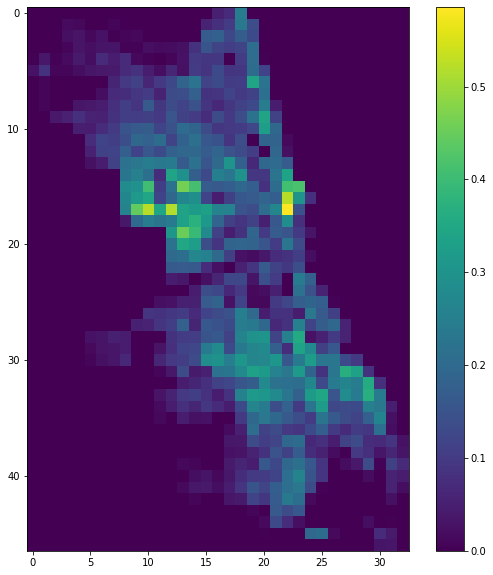

2019-11-21T15:50:15 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:50:15 | root | INFO | using time step: 1
fitted historic average: step (1) and max_steps (-1)
fitted historic average: step (1) and max_steps (-1)
2019-11-21T15:50:19 | root | INFO | f1_score: 0.7284583251890646 at index 119235, new threshold 0.08838762064613746
2019-11-21T15:50:19 | root | INFO | ======== ./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-21T15:50:22 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.4156140842506517
                RMSE:               0.5539706155639729
                ROC AUC:            0.787064020779656                
                Average Precision:  0.7467470621083027
                Precision:          0.5991519307109346
                Recall:             0.8516559263890224
                Accuracy: 

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-21T15:50:28 | root | INFO | 	t_range shape (17521,)
fitted historic average: step (24) and max_steps (-1)
2019-11-21T15:52:20 | root | INFO | class distribution: {0.0: 0.9651198397702193, 1.0: 0.03488016022978064}


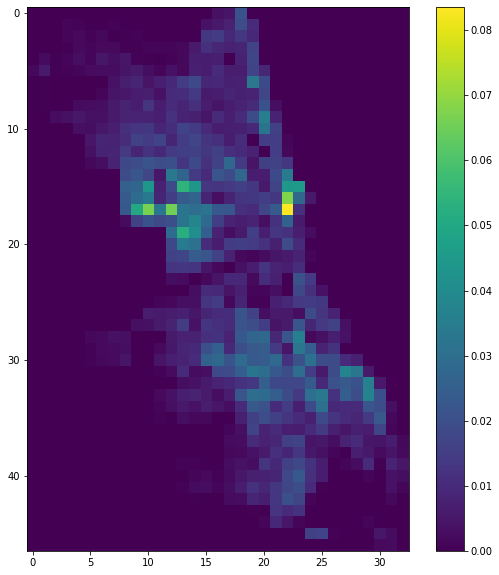

2019-11-21T15:52:24 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:52:24 | root | INFO | using time step: 24
fitted historic average: step (24) and max_steps (-1)
fitted historic average: step (24) and max_steps (-1)
2019-11-21T15:53:21 | root | INFO | f1_score: 0.16434407506052515 at index 122440, new threshold 0.030044273979593222
2019-11-21T15:53:21 | root | INFO | ======== ./data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-21T15:53:55 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                MAE:                0.041464799730775215
                RMSE:               0.17404795705564022
                ROC AUC:            0.7475318874675589                
                Average Precision:  0.10122757657188522
                Precision:          0.11541058317157565
                Recall:             0.25753780673835663
                Accuracy:           0.9143523714178153
                MCC:                0.13205656360390458          
        
2019-11-21T15:53:55 | root | INFO | =====================================END=====================================

2019-11-21T15:53:55 | root | INFO | =====================================BEGIN=====================================
2019-11-21T15:54:02 | root | INFO | f1_score: 0.15376588423645135 at index 616, new threshold 0.02516098148679695
2019-11-21T15:54:02 | root | INFO | ======== ./data/processed/T1H-X850M-Y

In [5]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
  
    conf.data_path = f"./data/processed/{data_sub_path}/"
    
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "===t==================================================")

    log.info("=====================================BEGIN=====================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)

    conf.shaper_threshold = 0
    conf.shaper_top_k = -1

    # CRIME DATA
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
    
    # LOG CLASS DISTRIBUTION
    vals, counts = np.unique(data_group.targets,return_counts=True)
    counts = counts/np.sum(counts)
    dist = dict(zip(vals,counts))
    log.info(f"class distribution: {dist}")

    test_set_size = data_group.testing_set.target_shape[0]
    crimes = data_group.shaper.unsqueeze(data_group.crimes)
    im(crimes.mean(0)[0])
    crimes = data_group.crimes
    t_range = data_group.t_range

    # -----------HISTORIC AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Historic Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    # time step in this context is used for 
    freqstr = t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))
        
    log.info(f"using time step: {time_step}")

    test_set_size = data_group.testing_set.target_shape[0]

    ha = HistoricAverage(step=time_step)
    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_crimes_ha = ha.fit_transform(data_group.crimes[:,0:1])[:,0]
    
    ha.fit(data_group.crimes[:,0:1])
#     ha.max_steps = -1
    all_crimes_ha = ha.transform(data_group.crimes[:,0:1])[:,0]
    
    all_t_range = data_group.t_range

    tst_crimes_ha = all_crimes_ha[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_crimes_ha[time_step+1:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[time_step+1:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_probas_pred = tst_crimes_ha
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------HISTORIC AVERAGE

    # -----------GLOBAL AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Global Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")


    test_set_size = data_group.testing_set.target_shape[0]

    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets

    trn_crimes = all_crimes[:-test_set_size]
    trn_targets = all_targets[:-test_set_size]

    tst_crimes = all_crimes[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_mean = np.mean(trn_crimes,axis=0,keepdims=True)  # keep dims used to make scalar product easy
    trn_ones = np.ones_like(trn_crimes,dtype=np.float)
    trn_probas_pred = trn_mean*trn_ones

    thresh = best_threshold(y_true=trn_targets,
                            probas_pred=trn_probas_pred) # should only come from the train predictions

    # only use the training sets - mean
    tst_ones = np.ones_like(tst_crimes,dtype=np.float)
    tst_probas_pred = trn_mean*tst_ones

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------GLOBAL AVERAGE
    
    
        
    # ------------PREVIOUS TIME STEP
    # Create model folder and setup logging for model
    conf.model_name = "Previous Time Step"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")


    test_set_size = data_group.testing_set.target_shape[0]

    all_probas_pred = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_t_range = data_group.t_range

    tst_probas_pred = all_probas_pred[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_probas_pred[:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)
    
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # ------------PREVIOUS TIME STEP
    
#    --------------    --------------    --------------    --------------    --------------    --------------

#     # ------------Uniform Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Uni. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     window_len=time_step

#     ma = UniformMovingAverage(window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Uniform Moving Average
    
#     # ------------Exponential Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Exp. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     alpha=1e-2
#     window_len=time_step

#     ma = ExponentialMovingAverage(alpha=alpha,window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Exponential Moving Average
    
#     # ------------Triangular Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Tri. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     window_len=time_step

#     ma = TriangularMovingAverage(window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Triangular Moving Average

2019-11-21T15:55:16 | root | INFO | T3H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-21T15:55:16 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.283209  0.106314  0.753655        0.246152   0.227663   
Ind-Hawkes Model      0.280383  0.112845  0.732139        0.229116   0.213769   
Global Average        0.284799  0.107550  0.731417        0.210336   0.193046   
Hawkes General Model  0.285977  0.105843  0.699702        0.189770   0.186427   
Previous Time Step    0.294179  0.104064  0.545570        0.105401   0.170390   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.452580  0.302938  0.816567           0.226921  
Ind-Hawkes Model      0.426486  0.284791  0.811342           0.204780  
Global Average        0.487095  

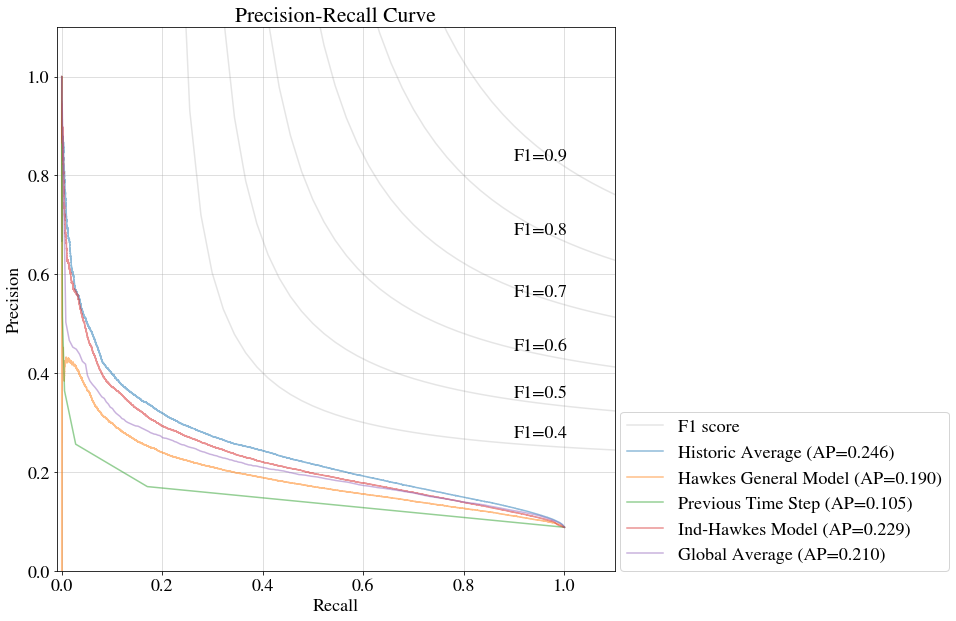

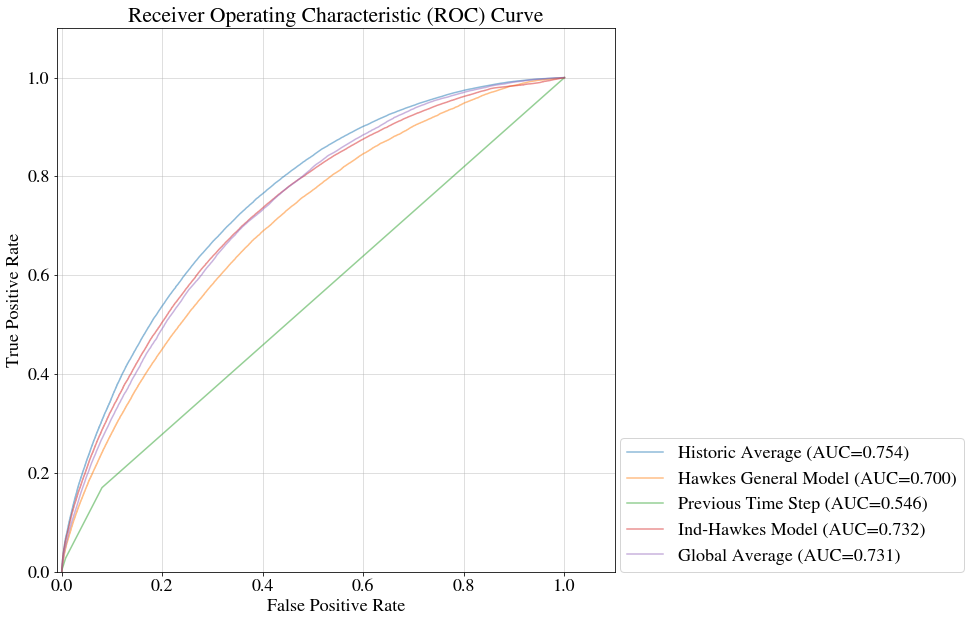

2019-11-21T15:55:19 | root | INFO | T24H-X85M-Y110M_2013-01-01_2015-01-01

2019-11-21T15:55:19 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.195658  0.048844  0.686080        0.109543   0.135966   
Global Average        0.195663  0.048873  0.685776        0.108357   0.126715   
Ind-Hawkes Model      0.192595  0.065421  0.677452        0.106497   0.123055   
Previous Time Step    0.201242  0.047975  0.523035        0.044625   0.083511   
Hawkes General Model  0.197723  0.046742  0.500000        0.039646   0.039646   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.228323  0.170437  0.911882           0.131832  
Global Average        0.254379  0.169164  0.900935           0.131215  
Ind-Hawkes Model      0.250927  

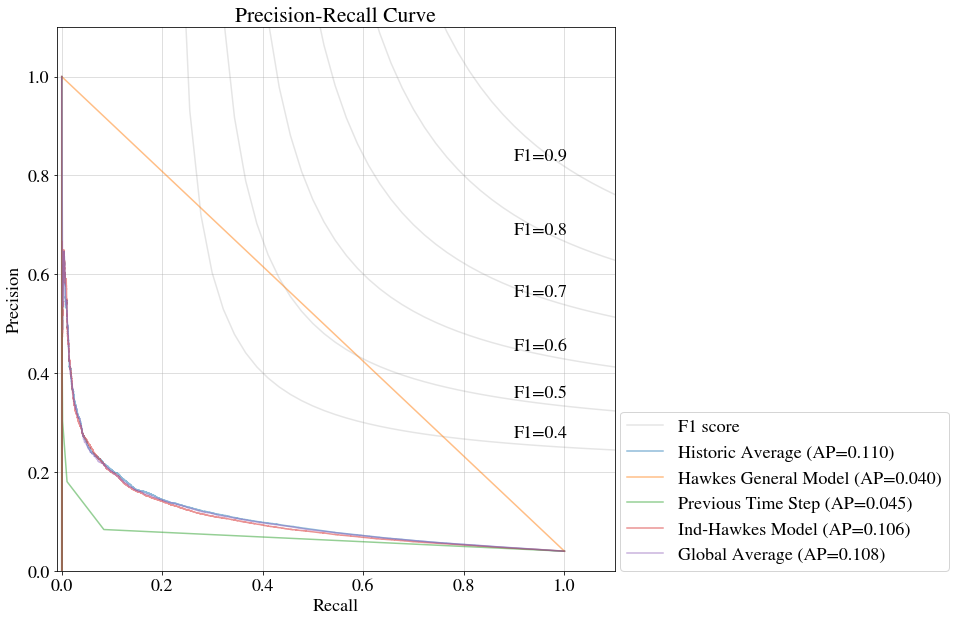

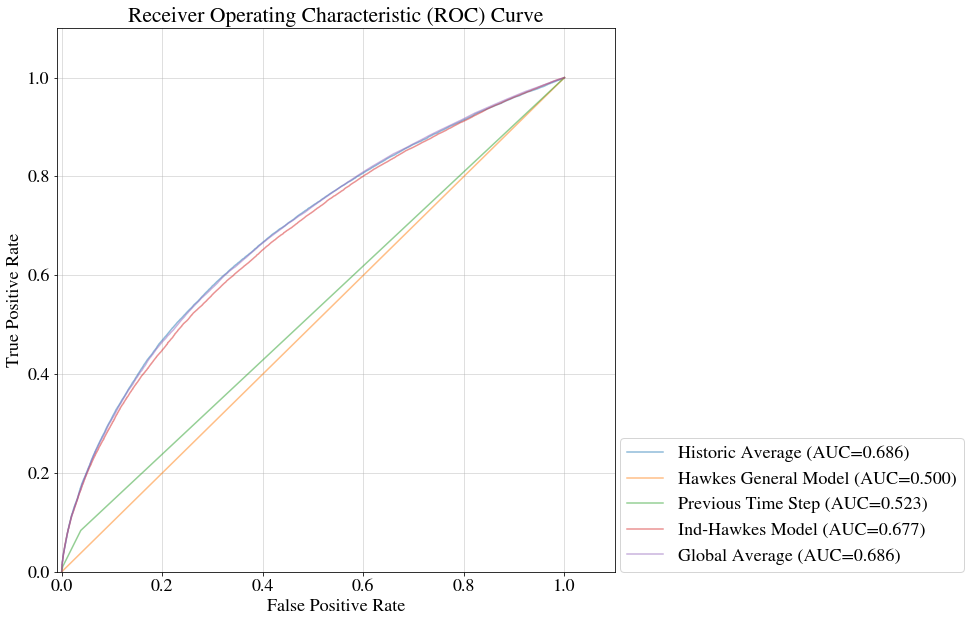

2019-11-21T15:55:21 | root | INFO | T1H-X1700M-Y1760M_2013-01-01_2015-01-01

2019-11-21T15:55:21 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.303039  0.128158  0.755682        0.268672   0.244779   
Ind-Hawkes Model      0.302050  0.131107  0.742548        0.259317   0.240920   
Hawkes General Model  0.306032  0.127202  0.728312        0.238383   0.225246   
Global Average        0.305278  0.130063  0.731534        0.225963   0.211831   
Previous Time Step    0.319286  0.124733  0.552144        0.125175   0.196259   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.503600  0.329434  0.787185           0.240860  
Ind-Hawkes Model      0.471870  0.318980  0.790848           0.227100  
Hawkes General Model  0.460010

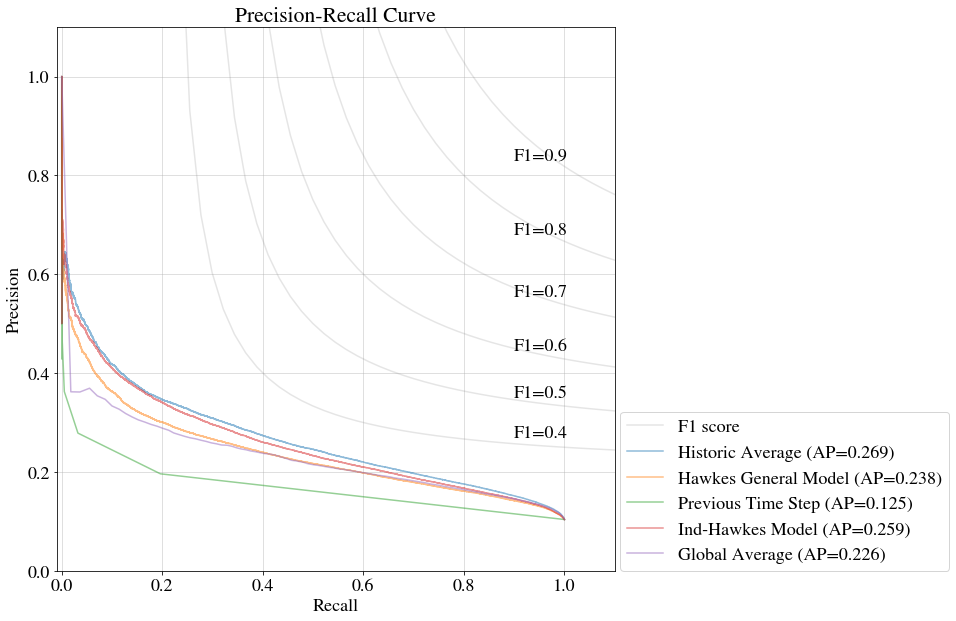

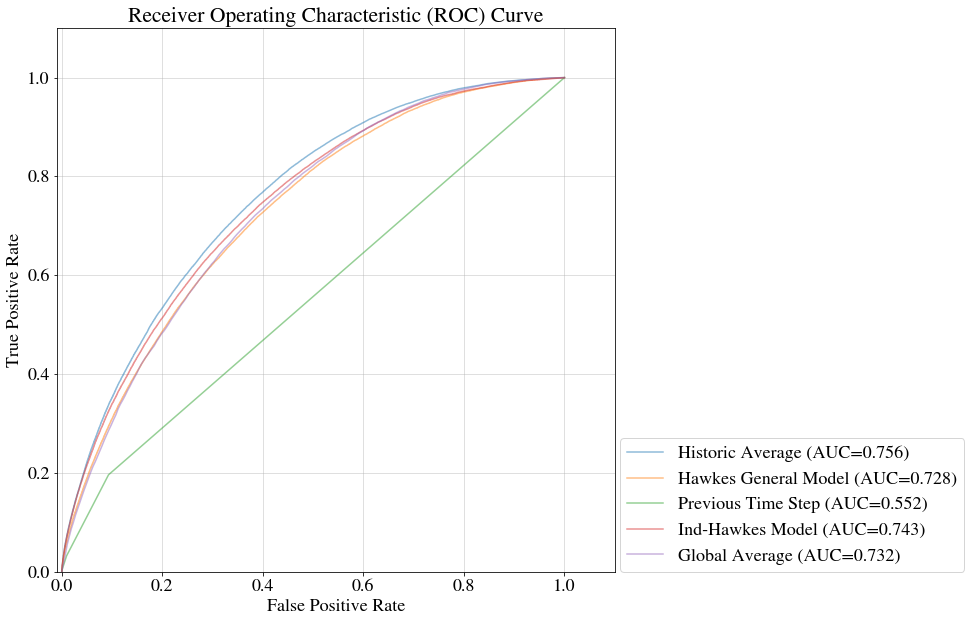

2019-11-21T15:55:23 | root | INFO | T12H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-21T15:55:23 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.465482  0.288815  0.768708        0.570248   0.449986   
Ind-Hawkes Model      0.416661  0.310532  0.755649        0.541977   0.443134   
Global Average        0.468335  0.292430  0.754147        0.537236   0.438578   
Hawkes General Model  0.476030  0.298982  0.740172        0.528419   0.430337   
Previous Time Step    0.489517  0.292910  0.581426        0.337455   0.278816   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.741489  0.560078  0.675228           0.351912  
Ind-Hawkes Model      0.723646  0.549670  0.669401           0.335031  
Global Average        0.728241 

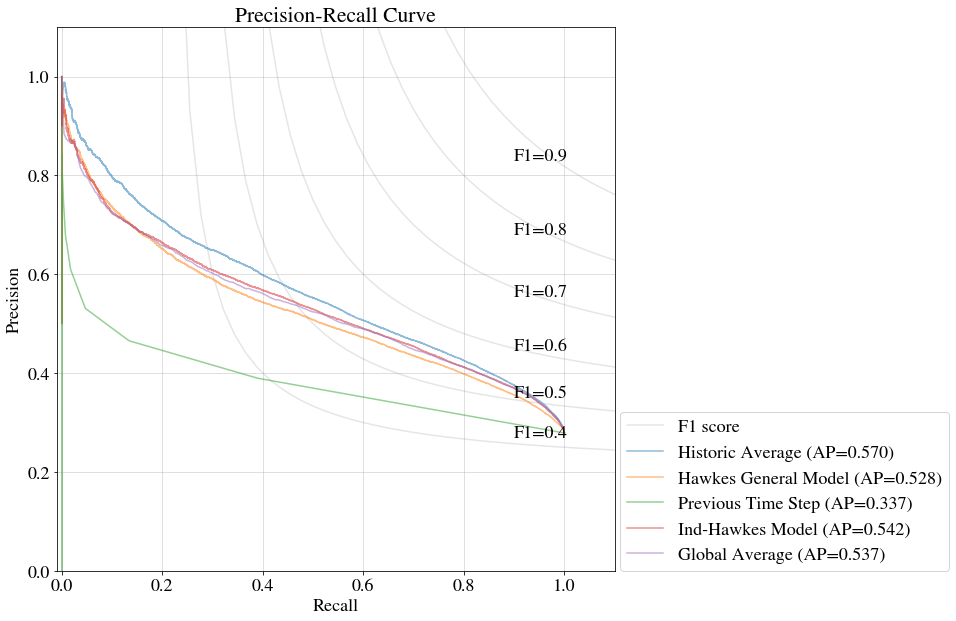

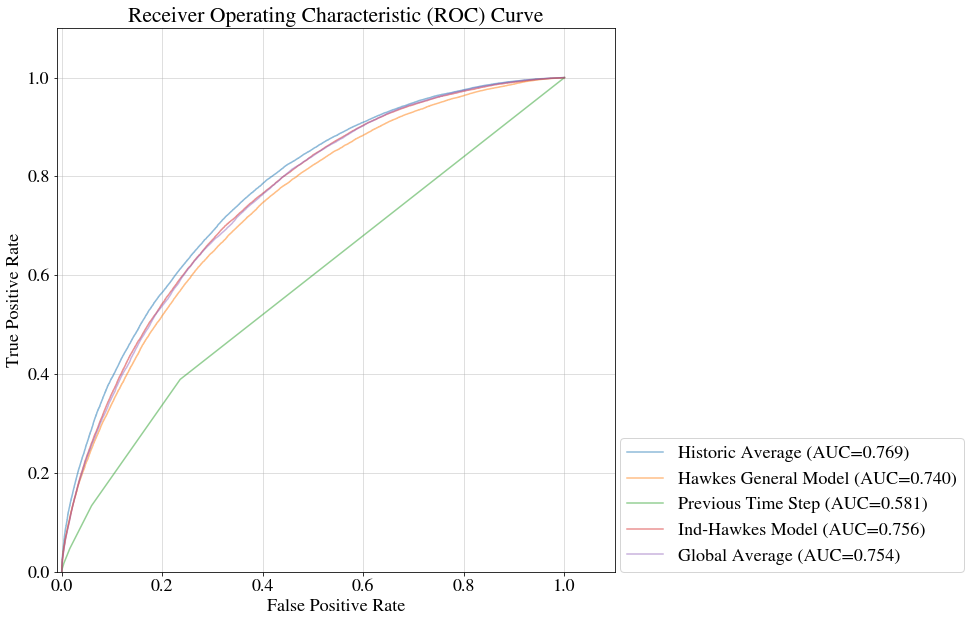

2019-11-21T15:55:25 | root | INFO | T24H-X850M-Y880M_2013-01-01_2017-01-01

2019-11-21T15:55:25 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.568508  0.418447  0.780098        0.732258   0.605011   
Global Average        0.568439  0.418421  0.779865        0.731426   0.591743   
Ind-Hawkes Model      0.440298  0.366796  0.778737        0.730931   0.600985   
Hawkes General Model  0.610289  0.437982  0.750142        0.702393   0.569616   
Previous Time Step    0.582188  0.418037  0.645914        0.571206   0.444358   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.818631  0.695794  0.681919           0.397014  
Global Average        0.847433  0.696875  0.672406           0.392381  
Ind-Hawkes Model      0.823894 

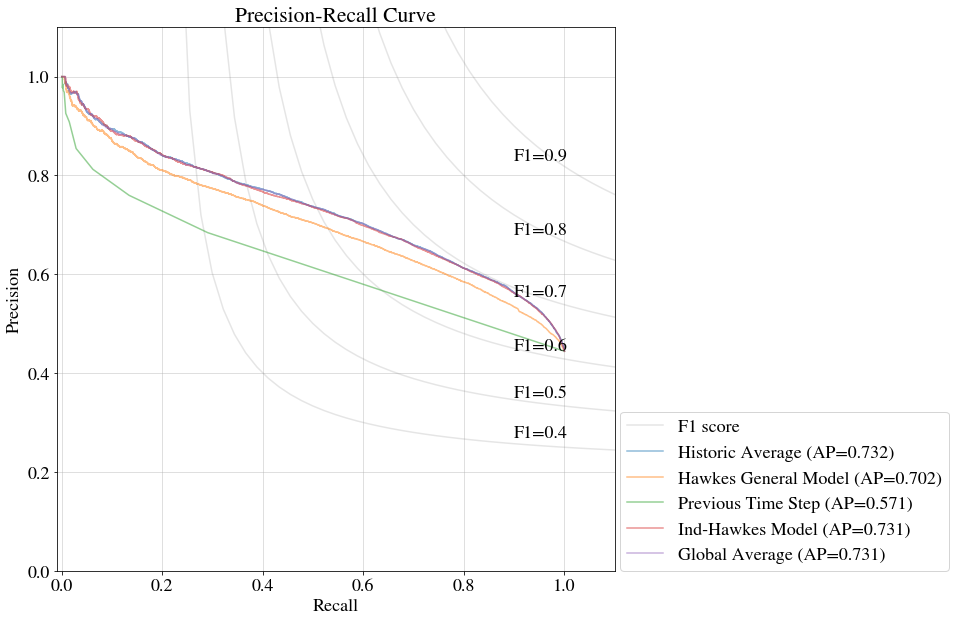

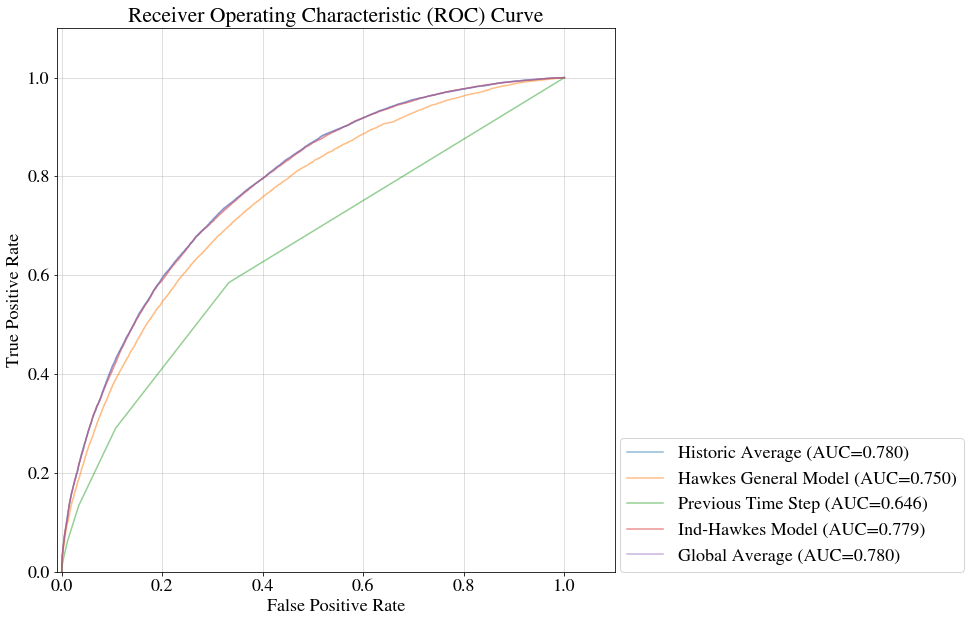

2019-11-21T15:55:27 | root | INFO | T24H-X255M-Y220M_2013-01-01_2015-01-01

2019-11-21T15:55:27 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.285061  0.104306  0.702975        0.211051   0.207601   
Global Average        0.285044  0.104421  0.701783        0.209654   0.197510   
Ind-Hawkes Model      0.275119  0.135496  0.696804        0.207673   0.199350   
Hawkes General Model  0.285996  0.110001  0.632827        0.161489   0.158959   
Previous Time Step    0.292850  0.101824  0.537794        0.100964   0.087233   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.382951  0.269243  0.818665           0.186804  
Global Average        0.416129  0.267876  0.801578           0.185448  
Ind-Hawkes Model      0.397428 

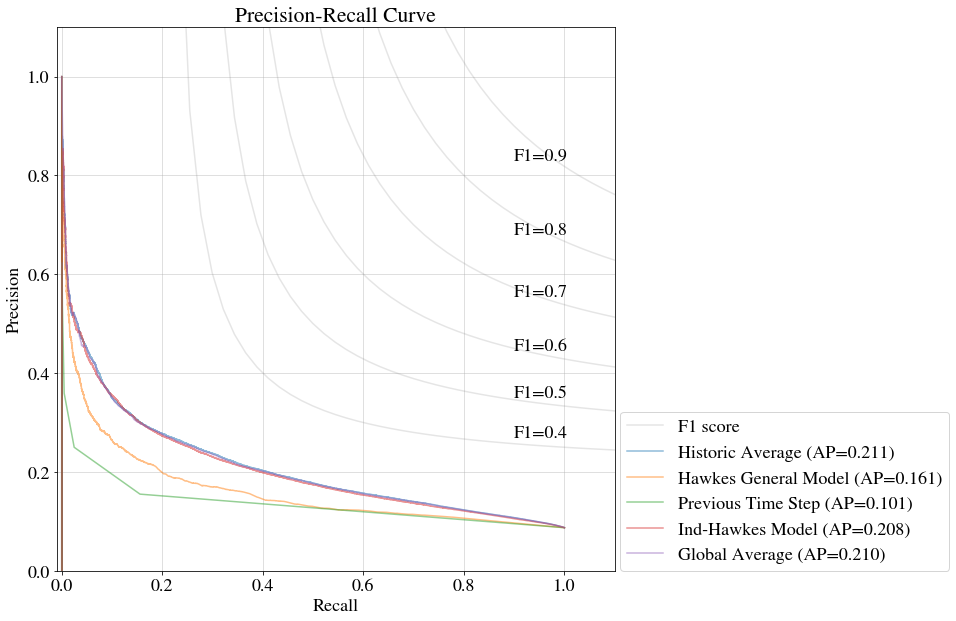

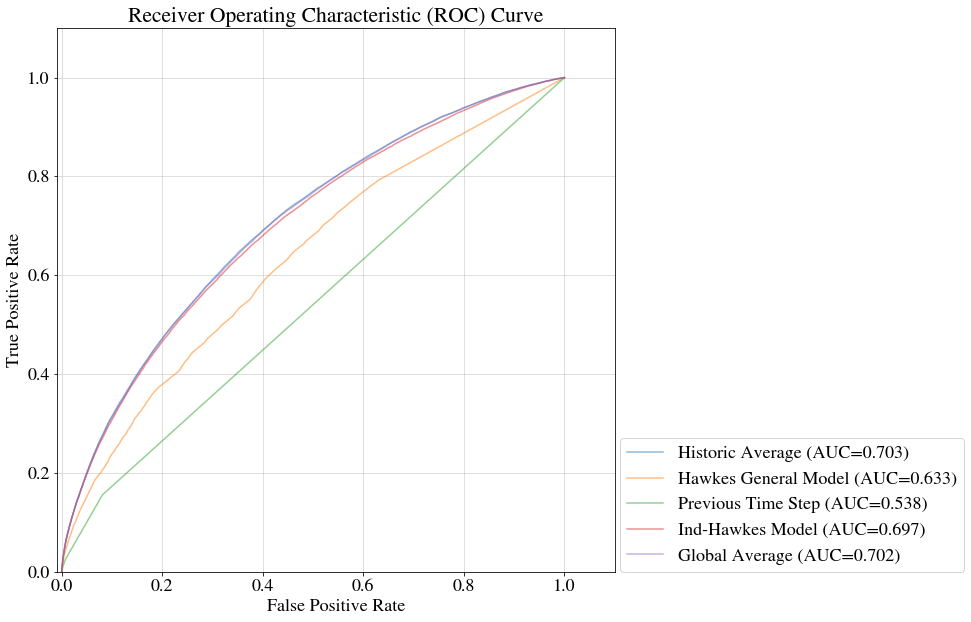

2019-11-21T15:55:28 | root | INFO | T6H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-21T15:55:29 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.369956  0.183577  0.757421        0.389893   0.328744   
ST-RESNET             0.369818  0.183563  0.751722        0.385012   0.334593   
Ind-Hawkes Model      0.354763  0.203987  0.740790        0.363636   0.303038   
Global Average        0.372429  0.186051  0.738640        0.350760   0.298332   
Hawkes General Model  0.375404  0.184262  0.713729        0.326844   0.290961   
Previous Time Step    0.387756  0.182491  0.559526        0.193322   0.161129   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.590978  0.422477  0.739659           0.291131  
ST-RESNET             0

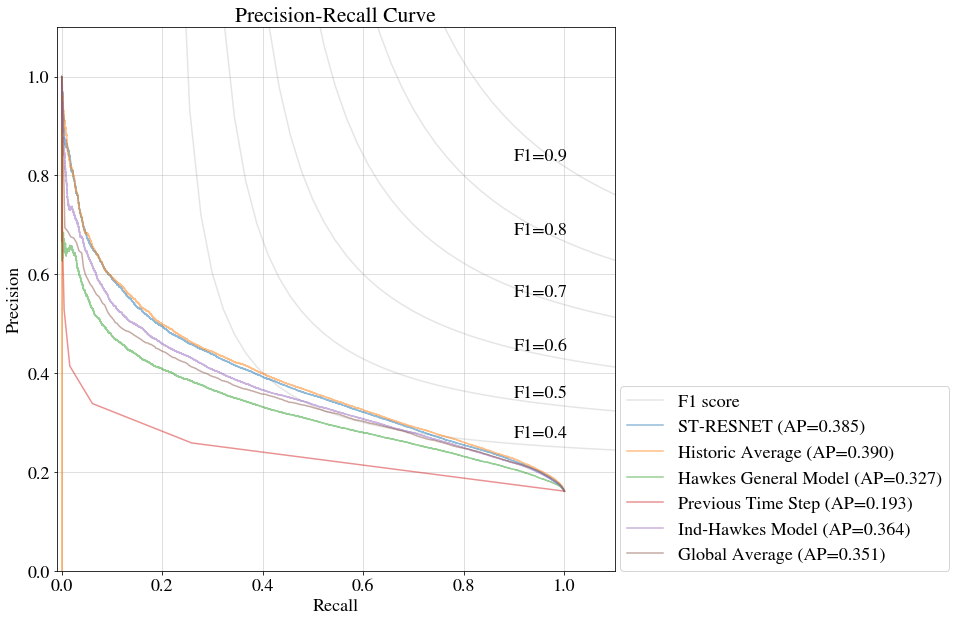

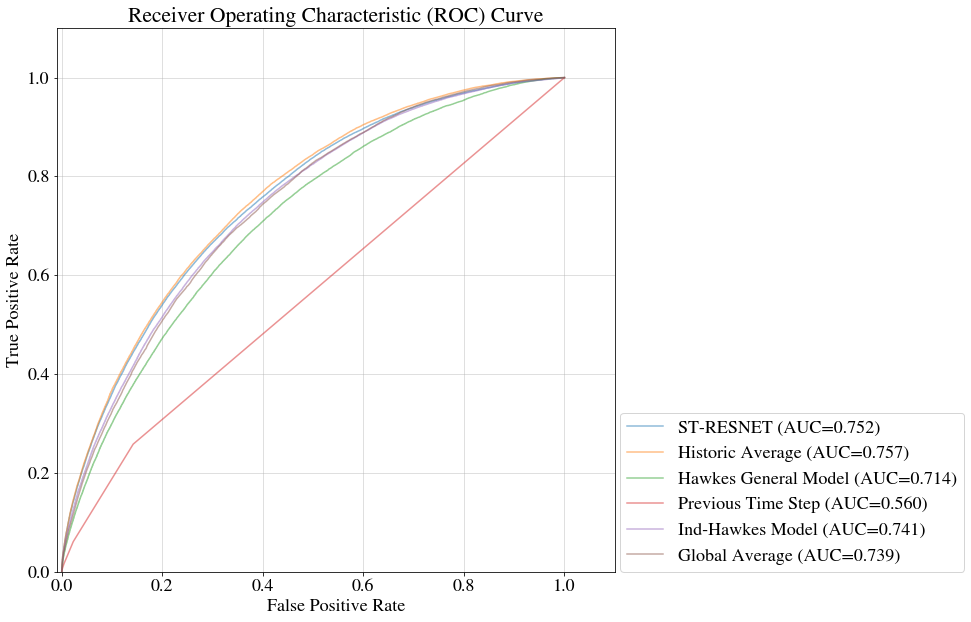

2019-11-21T15:55:32 | root | INFO | T24H-X425M-Y440M_2013-01-01_2015-01-01

2019-11-21T15:55:32 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.401172  0.211124  0.730948        0.405234   0.338722   
Global Average        0.401071  0.211297  0.730296        0.403833   0.331204   
Ind-Hawkes Model      0.369783  0.252222  0.728220        0.402632   0.329872   
Hawkes General Model  0.402221  0.225438  0.672906        0.343329   0.294995   
Previous Time Step    0.414143  0.207293  0.569146        0.233949   0.188700   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.599856  0.432962  0.703509           0.271635  
Global Average        0.618894  0.431492  0.692262           0.268789  
Ind-Hawkes Model      0.617311 

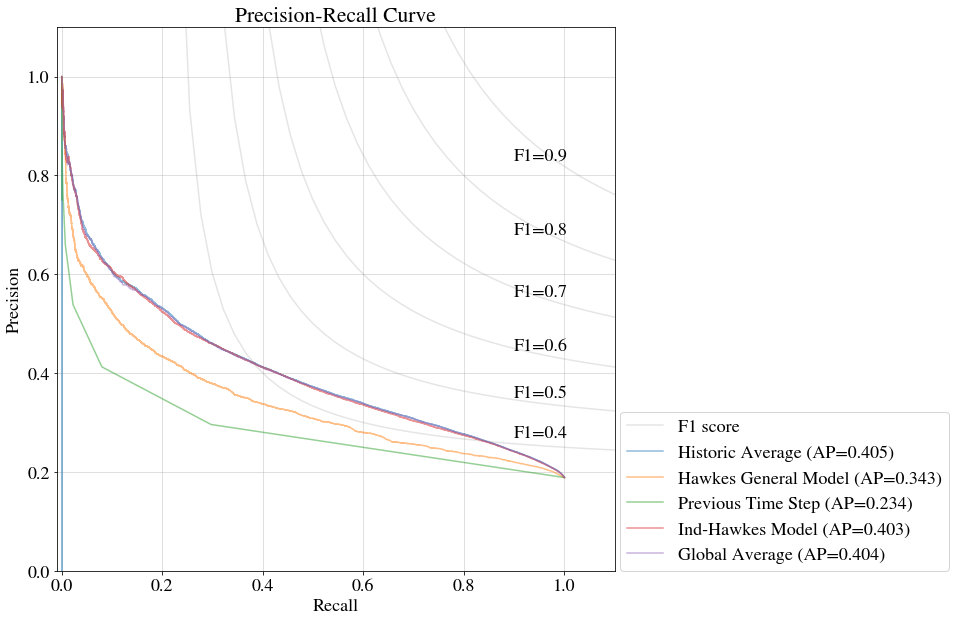

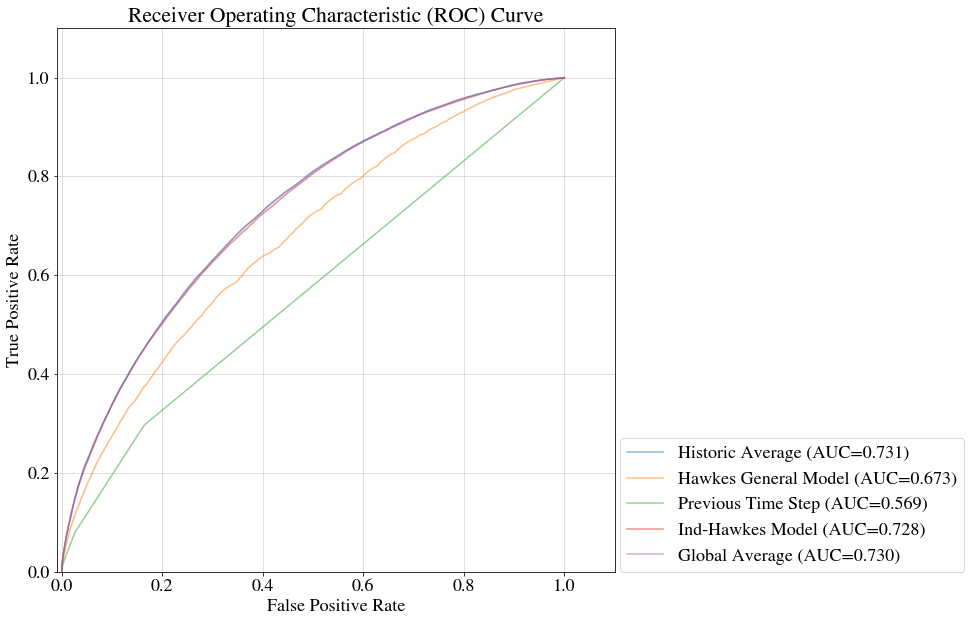

2019-11-21T15:55:34 | root | INFO | T24H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-21T15:55:34 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.553971  0.415614  0.787064        0.746747   0.599152   
Global Average        0.553563  0.415520  0.786669        0.745822   0.591271   
Ind-Hawkes Model      0.434889  0.361993  0.785569        0.744832   0.590266   
Hawkes General Model  0.563287  0.440588  0.764971        0.725511   0.581655   
Previous Time Step    0.574001  0.415492  0.653737        0.585656   0.448804   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.851656  0.703431  0.677703           0.401255  
Global Average        0.865153  0.702460  0.671070           0.396162  
Ind-Hawkes Model      0.862396 

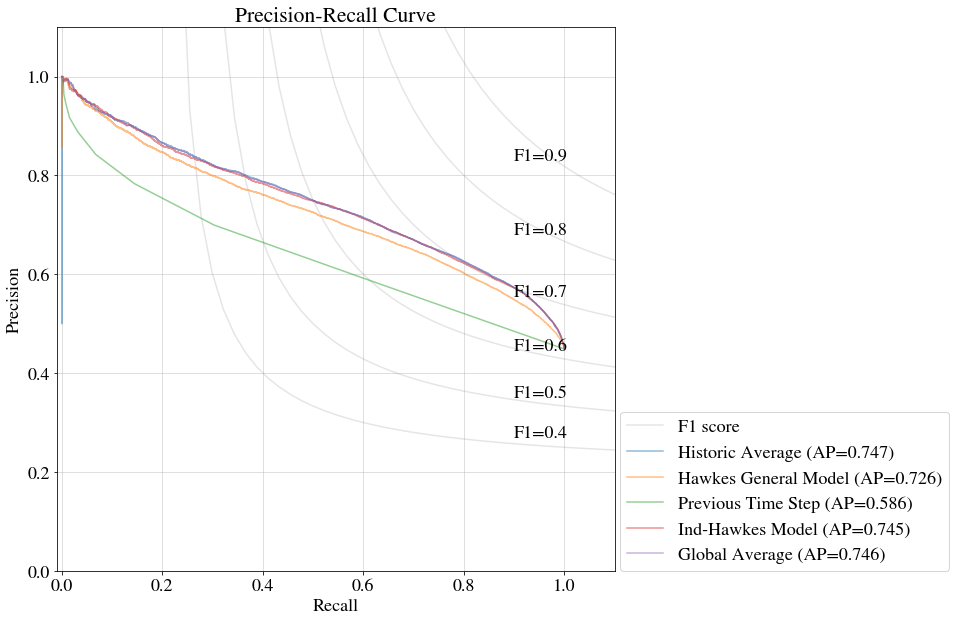

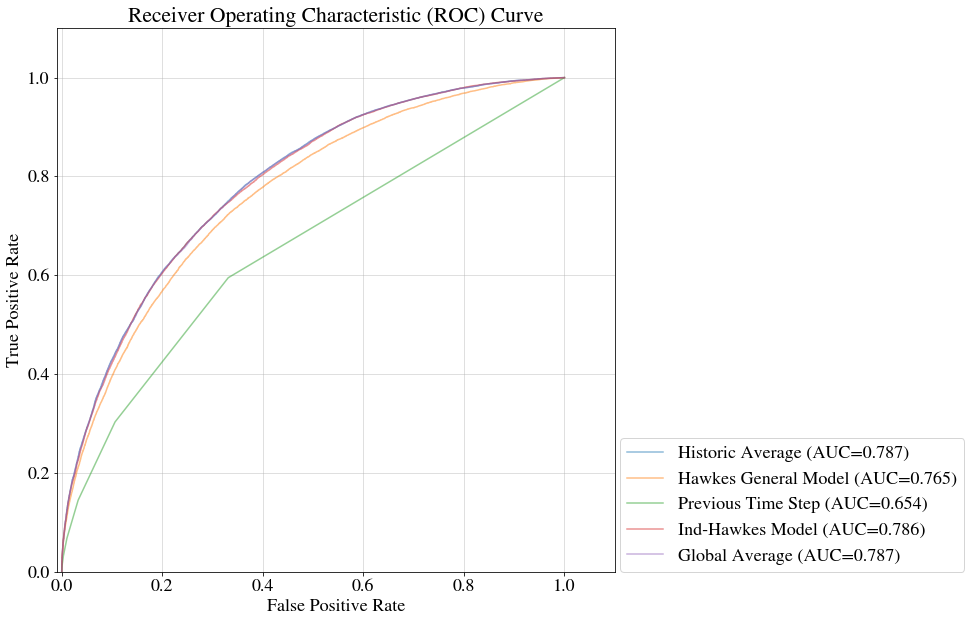

2019-11-21T15:55:35 | root | INFO | T1H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-21T15:55:36 | root | INFO | 
                          RMSE       MAE   ROC AUC  Avg. Precision  Precision  \
Model Name                                                                      
Historic Average      0.174048  0.041465  0.747532        0.101228   0.115411   
Ind-Hawkes Model      0.174312  0.041220  0.710275        0.090832   0.110284   
Global Average        0.174561  0.041751  0.727132        0.082813   0.095176   
Hawkes General Model  0.174904  0.040787  0.681687        0.069977   0.086382   
Previous Time Step    0.182553  0.040181  0.522583        0.035261   0.075180   

                        Recall  F1 Score  Accuracy  Matthews Corrcoef  
Model Name                                                             
Historic Average      0.257538  0.159393  0.914352           0.132057  
Ind-Hawkes Model      0.214957  0.145777  0.920571           0.115325  
Global Average        0.275203  

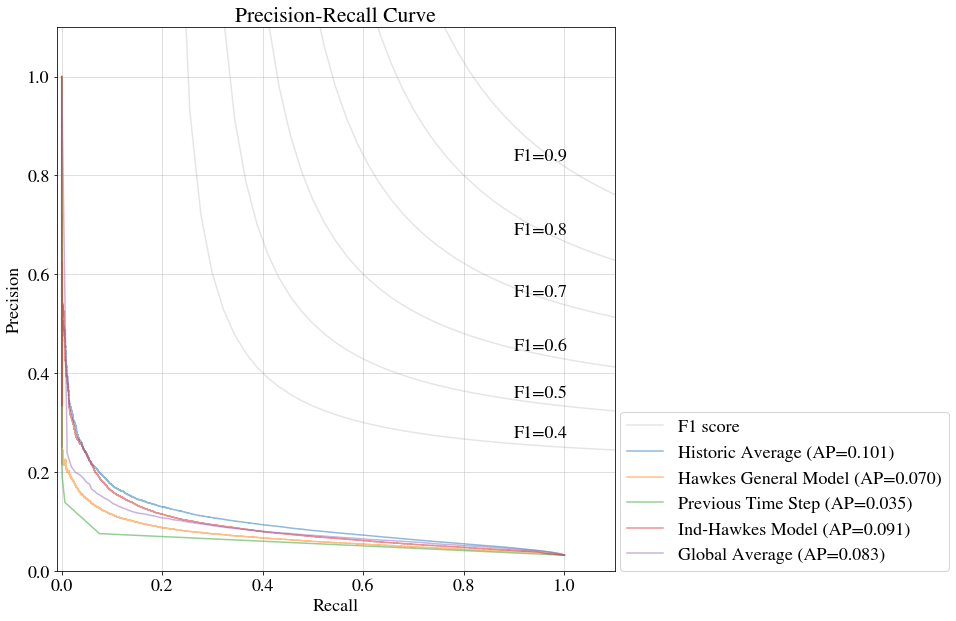

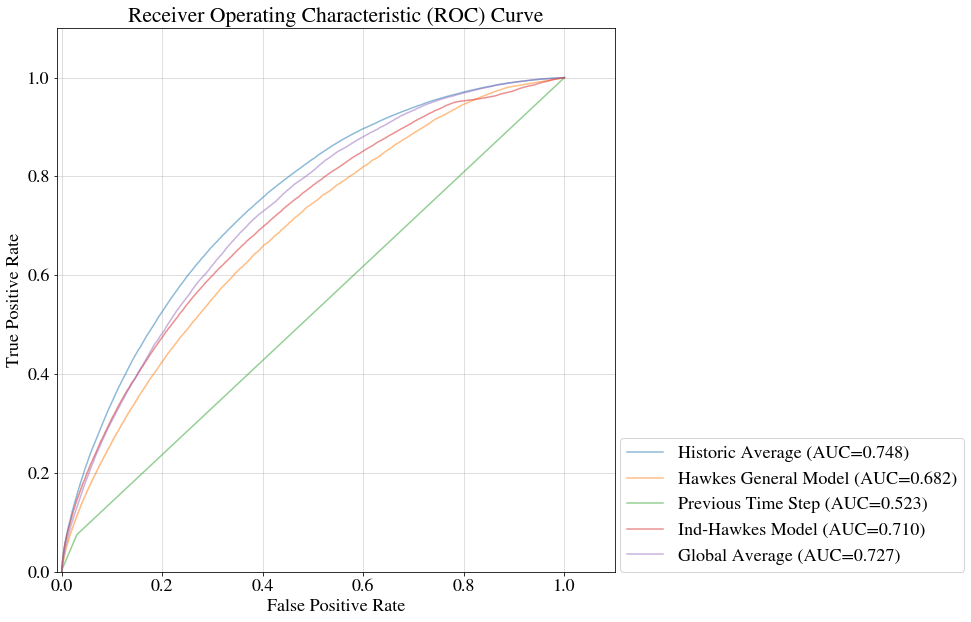

In [6]:
# data_path = conf.model_path[:conf.model_path.find("models")]
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    compare_models(data_path)

In [8]:
df = get_all_metrics()
df

,Model,dt,dx,dy,start_date,stop_date,MAE,RMSE,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,Matthews Corrcoef
20,Historic Average,24,850,880,2013-01-01,2017-01-01,0.418447,0.568508,0.780098,0.732258,0.605011,0.818631,0.695794,0.681919,0.397014
24,Global Average,24,850,880,2013-01-01,2017-01-01,0.418421,0.568439,0.779865,0.731426,0.591743,0.847433,0.696875,0.672406,0.392381
23,Ind-Hawkes Model,24,850,880,2013-01-01,2017-01-01,0.366796,0.440298,0.778737,0.730931,0.600985,0.823894,0.695003,0.678676,0.393531
21,Hawkes General Model,24,850,880,2013-01-01,2017-01-01,0.437982,0.610289,0.750142,0.702393,0.569616,0.833419,0.676717,0.646163,0.343643
22,Previous Time Step,24,850,880,2013-01-01,2017-01-01,0.418037,0.582188,0.645914,0.571206,0.444358,1.000000,0.615302,0.444358,0.000000
41,Historic Average,24,850,880,2013-01-01,2015-01-01,0.415614,0.553971,0.787064,0.746747,0.599152,0.851656,0.703431,0.677703,0.401255
45,Global Average,24,850,880,2013-01-01,2015-01-01,0.415520,0.553563,0.786669,0.745822,0.591271,0.865153,0.702460,0.671070,0.396162
44,Ind-Hawkes Model,24,850,880,2013-01-01,2015-01-01,0.361993,0.434889,0.785569,0.744832,0.590266,0.862396,0.700842,0.669573,0.392516
42,Hawkes General Model,24,850,880,2013-01-01,2015-01-01,0.440588,0.563287,0.764971,0.725511,0.581655,0.840884,0.687650,0.657156,0.363065
43,Previous Time Step,24,850,880,2013-01-01,2015-01-01,0.415492,0.574001,0.653737,0.585656,0.448804,1.000000,0.619551,0.448804,0.000000


--------


## [Hawkes Model](https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesSumExpKern.html)
does support multi variate but we are only using univariate for now
### Data Analysis Hawks-proces using the EM kernel